# NOTES
    the weibull and poisson functions work correctly now, but don't make much sense
    the weibull and poisson functions are exactly equivalent
    the probabilistic model makes no sense for extremes
        eg, 2B yr avg to transition from new star to habitable planet
            might be habitable within 1M years (0.05% chance)
            this adds up and dominates the calculations
        these issues end up massively out-populating the steady state solution (the orignial Drake Equation)

In [1]:
# import custom functions from drakefunctions.py
from drakefunctions import *

In [3]:
# import modules

import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:_.0f}'.format)
from scipy.stats import poisson
from scipy.special import gamma  # not the one from scipy.stats
from math import factorial, exp, log
import datetime, time
from decimal import *

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
%matplotlib inline
mpl.rcParams["axes.formatter.min_exponent"] = 20  # no scientific notation in graphs
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = 10   # pad is in points... default is 6
import seaborn as sns
sns.set_theme()

In [4]:
# CONSTANTS treated as variables for simulation

# inputs to the Drake equation
default_params = dict(
    # time step increments for calculations
    YEAR_STEPS = 1_000_000,
    # galactic attributes
    NUM_GALAXY = 100_000_000_000,  # number of stars in a galaxy
    GALAXY_RADIUS_LYR = 50_000,  # radius of the galaxy in lightyears
    MODERN_ERA = 10_000_000_000,  # years since 2nd gen stars, order of magnitude approx
    # pseudo-constants (treated as constants until Monte Carlo simulation)
    RS = 2, 
    FP = 1, 
    NE = 0.4, 
    FL = 1, 
    FI = 1, 
    FC = 0.1, 
    L = 1000,
    YEARS_PLANETS_TO_HABITABLE = 2_000_000_000, 
    YEARS_HABITABLE_TO_LIFE = 1_000_000_000, 
    YEARS_LIFE_TO_COMPLEX_LIFE = 1_000_000_000, 
    YEARS_COMPLEX_TO_INTELLIGENCE = 200_000_000, 
    YEARS_INTELLIGENCE_TO_CULTURE = 20_000_000, 
    YEARS_CULTURE_TO_TECH = 200_000, 
    EXTINCTION_SIMPLE = 5_000_000_000, 
    EXTINCTION_COMPLEX = 2_000_000_000, 
    EXTINCTION_INTELLIGENT = 200_000_000, 
    EXTINCTION_CULTURAL = 1_000_000, 
    # EXTINCTION_TECHNOLOGICAL = L,
    WEIBULL_SHAPE_PARAMETER = 0.4,  # k
    WEIBULL_SCALE_PARAMETER = 20_000  # lambda    
)

random_params = dict(
    # time step increments for calculations
    YEAR_STEPS = [1_000_000],
    # galactic attributes
    NUM_GALAXY = [100_000_000_000],  # number of stars in a galaxy
    GALAXY_RADIUS_LYR = [50_000],  # radius of the galaxy in lightyears
    MODERN_ERA = [10_000_000_000],  # years since 2nd gen stars, order of magnitude approx
    # pseudo-constants (treated as constants until Monte Carlo simulation)
    RS = [1, 2, 3],
    FP = [0.05, 0.2, 0.5, 1.0, 2.0],
    NE = [0.02, 0.1, 0.4, 1.0],
    FL = [0.01, 0.1, 1],
    FI = [0.01, 0.1, 1],
    FC = [0.01, 0.1, 1],
    L = [100, 1_000, 10_000, 100_000, 1_000_000],
    YEARS_PLANETS_TO_HABITABLE = [1_000_000_000, 2_000_000_000, 3_000_000_000], 
    YEARS_HABITABLE_TO_LIFE = [100_000_000, 1_000_000_000, 5_000_000_000], 
    YEARS_LIFE_TO_COMPLEX_LIFE = [100_000_000, 1_000_000_000, 5_000_000_000, 10_000_000_000], 
    YEARS_COMPLEX_TO_INTELLIGENCE = [100_000, 1_000_000, 50_000_000, 200_000_000, 1_000_000_000], 
    YEARS_INTELLIGENCE_TO_CULTURE = [10_000, 100_000, 2_000_000, 20_000_000, 200_000_000], 
    YEARS_CULTURE_TO_TECH = [1_000, 10_000, 100_000, 200_000, 2_000_000], 
    EXTINCTION_SIMPLE = [200_000_000, 1_000_000_000, 2_000_000_000, 5_000_000_000],  # these are mass extinction events
    EXTINCTION_COMPLEX = [200_000_000, 1_000_000_000, 2_000_000_000], # these are mass extinction events
    EXTINCTION_INTELLIGENT = [10_000, 100_000, 1_000_000, 10_000_000, 200_000_000, 1_000_000_000], 
    EXTINCTION_CULTURAL = [1_000, 10_000, 100_000, 1_000_000, 10_000_000], 
    # EXTINCTION_TECHNOLOGICAL = L,
    WEIBULL_SHAPE_PARAMETER = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # k
    WEIBULL_SCALE_PARAMETER = [100, 250, 500, 750, 1000, 5_000, 10_000, 20_000, 50_000, 100_000]  # lambda
)


In [7]:
# initialise params
params = params_set(default_params)

# THE TIME DEPENDENT DRAKE EQUATION

In [ ]:
# UPDATE THE CALCULATION

# The Time Dependent Drake Equation
def TimeDependentDrake(params, output_year, P_tech_dominance=1.0, df_input="empty"):
    """
    trying to come up with a better approach
    """
    
    # proportion of cultural civilizations that are consumed when tech life emerges
    P_tech_dominance = P_tech_dominance
    
    # columns used
    index = 'year'
    columns = ['year', 'num_stars', 'num_planets', 'num_habitable_planets', 'num_life', 
           'num_complex_life', 'num_intelligent_life', 'num_cultural_life', 'N', 'N_extinct']
    
    # if there is an input dataframe, use that, otherwise, initialise at year 0
    if type(df_input) == pd.DataFrame:
        # start over at the last row in the input DataFrame
        history_of_life = df_input.iloc[[-1]]
        history_of_life.columns = columns[1:]  # CONFIRM THIS WORKS
    else:
        # start at year 0 with no life and no 2nd gen stars
        history_of_life = pd.DataFrame(
            [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 
            columns = columns,
            index=[0]
        ).set_index(index)
    
    # initialise variables with input dict
    current_year = history_of_life.index[-1]
    num_stars = history_of_life.num_stars.iloc[-1]
    num_planets = history_of_life.num_planets.iloc[-1]
    num_habitable_planets = history_of_life.num_habitable_planets.iloc[-1]
    num_life = history_of_life.num_life.iloc[-1]
    num_complex_life = history_of_life.num_complex_life.iloc[-1]
    num_intelligent_life = history_of_life.num_intelligent_life.iloc[-1]
    num_cultural_life = history_of_life.num_cultural_life.iloc[-1]
    N = history_of_life.N.iloc[-1]
    N_extinct = history_of_life.N_extinct.iloc[-1]

    while current_year < output_year:
        
        # increment year
        current_year += params['YEAR_STEPS']
        num_new_stars = star_formation(params, current_year, num_stars)
        
        # number of extinctions
        extinctions = new_extinctions(params, num_stars, num_life, num_complex_life, num_intelligent_life, num_cultural_life, N)
        num_life -= extinctions[0]
        num_complex_life -= extinctions[1]
        num_intelligent_life -= extinctions[2]
        num_cultural_life -= extinctions[3]
        N -= extinctions[4]
        N_extinct += extinctions[4]  # track technological extinctions
        
        # number of technological species
        new_tech_life = new_technological(params, num_cultural_life, N)
        N += new_tech_life
        
        # number of cultural civilizations
        num_cultural_life += transition(params, num_intelligent_life, num_cultural_life, params['YEARS_INTELLIGENCE_TO_CULTURE'])  
        # assumes only (1 - P_tech_dominance) cultural civilizations once one civilization gains tech
        # equivalent to neandrethal going extinct before we gain technology (probably because of us)
        num_cultural_life -= new_tech_life * P_tech_dominance
        
        # number of intelligent life
        num_intelligent_life += transition(params, num_complex_life, num_intelligent_life, params['YEARS_COMPLEX_TO_INTELLIGENCE'])
        
        # number of complex lifeforms
        num_complex_life += transition(params, num_life, num_complex_life, params['YEARS_LIFE_TO_COMPLEX_LIFE'])

        # number of simple lifeforms
        num_life += transition(params, num_habitable_planets, num_life, params['YEARS_HABITABLE_TO_LIFE'])
    
        # number of habitable planets
        num_habitable_planets += new_habitable(params, num_planets, num_habitable_planets)
        
        # number of planets
        num_planets += new_planets(params, num_new_stars)
        
        # number of stars
        num_stars += num_new_stars
        
        # append new values to the history of life dataframe
        templist = [current_year, num_stars, num_planets, num_habitable_planets, num_life, 
                    num_complex_life, num_intelligent_life, num_cultural_life, N, N_extinct]
                
        history_of_life = history_of_life.append(
            pd.DataFrame(
                [templist], 
                columns = columns,
                index=[current_year]
            ).set_index(index)
        )
    
    # shorten the names of columns before returning
    shorter_columns = ['n_star', 'n_planet', 'n_habitable', 'n_life', 'n_complex', 'n_int', 'n_cult',
                       'N', 'N_extinct']  
    history_of_life.columns = shorter_columns
    
    return history_of_life
    

In [110]:
# OLD TRANSITION FUNCTIONS

def transition(params, num_from, num_to, prob_of_transition):
    """
    TODO: rename prob_of_transition, it's an average time
    the number of previous stage that develop into new stage
        eg, the number of habitable planets that evolve life
    doesn't track planets, just uses ratios to approximate expectations
    subtracts already transitioned life-stages
    doesn't apply to technological species - treated differently
    """
    return (num_from - num_to) * prob_poisson(prob_of_transition, params['YEAR_STEPS'])
    

def new_technological(params, num_cultural_life, N):
    """
    the number of planets with cultural life that develop technological life
    doesn't track planets, uses ratios to approximate expectations
    doesn't account for number of tech species, ie, doesn't use (num_cultural_life - num_tech_life)
    this is because of P_tech_dominance:
        some proportion of cultural species transition or otherwise become
        extinct as a result of sharing a planet with a technological species
        P_tech_dominance is not a CONSTANT, it is treated as an input to TimeDependentDrake()
    FC is the percentage of intelligent species that develop communication
        used as a ratio to make sure growth rate is commutatitve
    """
    
    return num_cultural_life * prob_poisson(params['YEARS_CULTURE_TO_TECH'] / params['FC'], params['YEAR_STEPS'])

In [104]:
# NEW TRANSITION FUNCTIONS = NOT BETTER

def transition(params, num_from, num_to, prob_of_transition):
    transition = (num_from - num_to) * (params['YEAR_STEPS'] / prob_of_transition)
    return (num_from - num_to) * min(transition, 1)

def new_technological(params, num_cultural_life, N):
    transition = num_cultural_life * (params['YEAR_STEPS'] / params['YEARS_CULTURE_TO_TECH'])
    return num_cultural_life * min(transition, 1 * params['FC'])

In [105]:
print(new_technological(params, 1000, 0))

100.0


In [108]:
star_formation(params, 10_000_000_000, 100_000_000_000)

0.0

In [103]:
%%time

### ORIGINAL PROB TRANSFER FUNCTIONS - poisson ###

history_of_life = TimeDependentDrake(params, output_year=1_000_000_000, P_tech_dominance=0.9)
# history_of_life.to_csv('OUTPUT_FILENAME.csv')  # SAVE FILE

history_of_life.iloc[::100, :]  # every 100M year
# 455 extinct civilisations within 100M years, not reasonable

Wall time: 1.57 s


n_star       n_planet   n_habitable        n_life  \
year                                                                   
0                       0              0             0             0   
100000000   5_796_686_127  2_318_674_451    57_118_743     1_818_863   
200000000  11_204_063_326  4_481_625_330   220_721_250    13_984_873   
300000000  16_250_786_932  6_500_314_773   478_299_361    44_923_674   
400000000  20_963_244_203  8_385_297_681   818_491_830   101_131_872   
500000000  25_365_744_833 10_146_297_933 1_230_986_007   187_464_823   
600000000  29_480_694_629 11_792_277_851 1_706_427_854   307_388_051   
700000000  33_328_753_902 13_331_501_561 2_236_339_607   463_196_546   
800000000  36_928_981_987 14_771_592_795 2_813_044_394   656_205_682   
900000000  40_298_969_146 16_119_587_659 3_429_597_227   886_917_089   
1000000000 43_454_957_035 17_381_982_814 4_079_721_832 1_155_162_451   

             n_complex      n_int    n_cult       N   N_extinct  
year                                                             
0                    0          0         0       0           0  
100000000       42_953      3_559       208      29         455  
200000000      658_197     97_620     5_890     832      28_348  
300000000    3_128_417    621_993    37_939   5_408     286_980  
400000000    9_240_405  2_204_986   135_214  19_356   1_410_865  
500000000   21_050_660  5_696_180   350_403  50_285   4_700_452  
600000000   40_708_510 12_078_497   744_556 107_025  12_283_956  
700000000   70_325_579 22_388_650 1_382_126 198_901  27_202_518  
800000000  111_882_345 37_653_550 2_326_999 335_165  53_430_365  
900000000  167_164_155 58_842_871 3_639_538 524_559  95_844_700  
1000000000 237_720_406 86_835_699 5_374_490 775_019 160_159_062

In [106]:
%%time

### NON-PROB TRANSFER FUNCTIONS - just ratios ###
### EVEN WORSE ###

history_of_life = TimeDependentDrake(params, output_year=1_000_000_000, P_tech_dominance=0.9)
# history_of_life.to_csv('OUTPUT_FILENAME.csv')  # SAVE FILE

history_of_life.iloc[::100, :]  # every 100M year
# 455 extinct civilisations within 100M years, not reasonable

Wall time: 1.34 s


n_star       n_planet   n_habitable        n_life  \
year                                                                   
0                       0              0             0             0   
100000000   5_796_686_127  2_318_674_451    57_118_743    55_998_603   
200000000  11_204_063_326  4_481_625_330   220_721_250   218_600_186   
300000000  16_250_786_932  6_500_314_773   478_299_361   475_296_606   
400000000  20_963_244_203  8_385_297_681   818_491_830   814_715_650   
500000000  25_365_744_833 10_146_297_933 1_230_986_007 1_226_534_638   
600000000  29_480_694_629 11_792_277_851 1_706_427_854 1_701_390_369   
700000000  33_328_753_902 13_331_501_561 2_236_339_607 2_230_796_700   
800000000  36_928_981_987 14_771_592_795 2_813_044_394 2_807_069_099   
900000000  40_298_969_146 16_119_587_659 3_429_597_227 3_423_255_584   
1000000000 43_454_957_035 17_381_982_814 4_079_721_832 4_073_073_487   

               n_complex         n_int        n_cult           N  \
year                                                               
0                      0             0             0           0   
100000000     54_869_992    53_725_753    50_714_450   1_825_801   
200000000    216_449_696   214_202_051   204_319_527   7_439_096   
300000000    472_243_812   468_965_293   448_846_260  16_401_471   
400000000    810_869_164   806_627_025   773_315_921  28_308_653   
500000000  1_221_993_047 1_216_849_682 1_167_762_794  42_793_670   
600000000  1_696_243_095 1_690_256_415 1_623_147_255  59_523_648   
700000000  2_225_124_789 2_218_348_572 2_131_276_227  78_196_883   
800000000  2_800_945_944 2_793_430_154 2_684_730_361  98_540_161   
900000000  3_416_747_583 3_408_538_667 3_276_797_380 120_306_304   
1000000000 4_066_240_647 4_057_381_800 3_901_411_041 143_271_921   

                N_extinct  
year                       
0                       0  
100000000      57_112_576  
200000000     487_855_458  
300000000   1_649_240_247  
400000000   3_855_838_591  
500000000   7_383_669_050  
600000000  12_473_766_278  
700000000  19_335_443_831  
800000000  28_149_276_532  
900000000  39_069_826_115  
1000000000 52_228_131_841

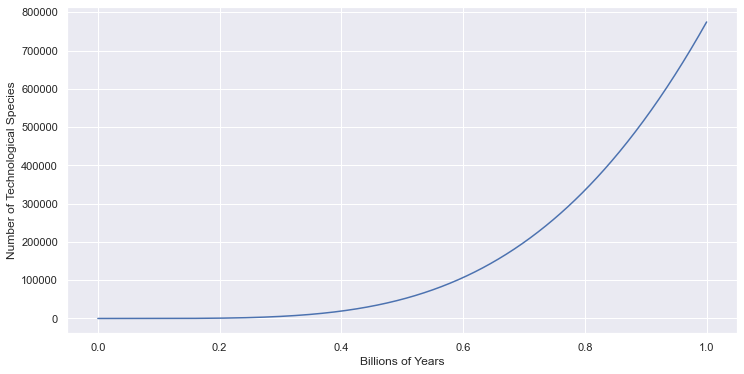

In [10]:
# plot of technological species over time

plt.figure(figsize=(12, 6))
plot = sns.lineplot(x=history_of_life.index/1_000_000_000, y=history_of_life.N);
plt.yticks(rotation=0);
plot.set_ylabel('Number of Technological Species');
plot.set_xlabel('Billions of Years');

# compare values of YEAR_STEPS 
    complex or higher are not working 
    num_life or higher are inconsistent with old odds calcs

In [42]:
%%time
params['YEAR_STEPS'] = 10_000_000
ts_10M = TimeDependentDrake(params, output_year=10_000_000_000, P_tech_dominance=1)

ts_10M.tail()

Wall time: 1.66 s


n_star       n_planet    n_habitable         n_life  \
year                                                                      
9960000000  95_049_310_897 38_019_724_359 36_956_349_231 35_331_631_432   
9970000000  95_050_301_035 38_020_120_414 36_961_666_107 35_340_437_238   
9980000000  95_051_290_975 38_020_516_390 36_966_958_378 35_349_206_571   
9990000000  95_052_280_717 38_020_912_287 36_972_226_168 35_357_939_557   
10000000000 95_053_270_261 38_021_308_104 36_977_469_599 35_366_636_320   

                 n_complex          n_int        n_cult        N    N_extinct  
year                                                                           
9960000000  22_765_440_925 11_538_831_259 4_316_514_984 -707_253 -374_811_412  
9970000000  22_773_246_725 11_542_969_200 4_318_069_449 -707_500 -375_518_666  
9980000000  22_781_022_336 11_547_091_276 4_319_617_958 -707_745 -376_226_165  
9990000000  22_788_767_852 11_551_197_536 4_321_160_531 -707_989 -376_933_910  
10000000000 22_796_483_365 11_555_288_028 4_322_697_186 -708_233 -377_641_900

In [107]:
ts_10M.head(11)
# extinctions cause negative values

n_star      n_planet  n_habitable    n_life  n_complex  \
year                                                                      
0                     0             0            0         0          0   
10000000    599_400_000   239_760_000            0         0          0   
20000000  1_194_610_793   477_844_317    1_198_800         0          0   
30000000  1_785_664_631   714_265_852    3_582_028    11_928          0   
40000000  2_372_593_499   949_037_400    7_135_447    47_319        117   
50000000  2_955_429_116 1_182_171_646   11_844_956   117_452        581   
60000000  3_534_202_937 1_413_681_175   17_696_590   233_356      1_730   
70000000  4_108_946_156 1_643_578_462   24_676_513   405_811      4_003   
80000000  4_679_689_708 1_871_875_883   32_771_023   645_352      7_942   
90000000  5_246_464_273 2_098_585_709   41_966_547   962_278     14_184   
100000000 5_809_300_275 2_323_720_110   52_249_643 1_366_645     23_458   

           n_int  n_cult  N  N_extinct  
year                                    
0              0       0  0          0  
10000000       0       0  0          0  
20000000       0       0  0          0  
30000000       0       0  0          0  
40000000       0       0  0          0  
50000000       6       0  0          0  
60000000      33       2  0          0  
70000000     113      12 -0          0  
80000000     295      42 -0         -0  
90000000     650     110 -0         -0  
100000000  1_271     242 -0         -0

In [43]:
%%time
params['YEAR_STEPS'] = 100_000_000
ts_100M = TimeDependentDrake(params, output_year=10_000_000_000, P_tech_dominance=1)

ts_100M.tail()

Wall time: 180 ms


n_star       n_planet    n_habitable         n_life  \
year                                                                      
9600000000  95_155_520_978 38_062_208_391 36_880_011_661 35_132_996_853   
9700000000  95_165_209_936 38_066_083_974 36_939_121_498 35_232_431_096   
9800000000  95_174_879_516 38_069_951_806 36_995_469_621 35_327_845_681   
9900000000  95_184_529_757 38_073_811_903 37_049_193_731 35_419_367_985   
10000000000 95_194_160_697 38_077_664_279 37_100_424_639 35_507_126_121   

                 n_complex          n_int        n_cult           N  \
year                                                                  
9600000000  22_982_710_236 13_460_390_175 8_062_119_156 -16_869_224   
9700000000  23_074_012_901 13_517_594_401 8_097_860_038 -16_945_142   
9800000000  23_161_871_909 13_572_666_651 8_132_278_718 -17_018_530   
9900000000  23_246_391_793 13_625_671_287 8_165_414_699 -17_089_128   
10000000000 23_327_674_420 13_676_670_940 8_197_306_703 -17_157_021   

               N_extinct  
year                      
9600000000  -777_640_929  
9700000000  -794_510_153  
9800000000  -811_455_295  
9900000000  -828_473_825  
10000000000 -845_562_954

In [44]:
ts_100M.head(11)

n_star       n_planet   n_habitable      n_life  \
year                                                                 
0                       0              0             0           0   
100000000   5_940_000_000  2_376_000_000             0           0   
200000000  11_470_728_000  4_588_291_200   118_800_000           0   
300000000  16_623_131_630  6_649_252_652   342_274_560  11_305_315   
400000000  21_425_639_248  8_570_255_699   657_623_465  42_678_128   
500000000  25_904_377_811 10_361_751_125 1_053_255_076 100_837_441   
600000000  30_083_370_903 12_033_348_361 1_518_679_879 190_767_514   
700000000  33_984_718_806 13_593_887_523 2_044_413_303 315_987_515   
800000000  37_628_762_328 15_051_504_931 2_621_887_014 478_786_353   
900000000  41_034_231_905 16_413_692_762 3_243_367_910 680_426_725   
1000000000 44_218_383_382 17_687_353_353 3_901_884_152 921_322_035   

             n_complex      n_int     n_cult       N  N_extinct  
year                                                             
0                    0          0          0       0          0  
100000000            0          0          0       0          0  
200000000            0          0          0       0          0  
300000000            0          0          0       0          0  
400000000    1_062_899          0          0       0          0  
500000000    4_929_318    393_918          0       0          0  
600000000   13_730_131  1_973_038    234_292       0          0  
700000000   29_768_277  5_820_876  1_177_163  -1_558          0  
800000000   55_356_503 13_193_332  3_479_607  -6_928     -1_558  
900000000   92_699_936 25_414_066  7_896_961 -18_494     -8_485  
1000000000 143_814_321 43_792_103 15_225_746 -38_490    -26_980

In [45]:
%%time
params['YEAR_STEPS'] = 1_000_000
ts_1M = TimeDependentDrake(params, output_year=10_000_000_000, P_tech_dominance=1)

ts_1M.tail()

Wall time: 15.9 s


n_star       n_planet    n_habitable         n_life  \
year                                                                      
9996000000  95_039_003_081 38_015_601_233 36_963_131_775 35_349_216_742   
9997000000  95_039_102_301 38_015_640_921 36_963_658_010 35_350_086_706   
9998000000  95_039_201_519 38_015_680_608 36_964_184_001 35_350_956_308   
9999000000  95_039_300_735 38_015_720_294 36_964_709_749 35_351_825_549   
10000000000 95_039_399_949 38_015_759_980 36_965_235_255 35_352_694_429   

                 n_complex          n_int      n_cult           N  \
year                                                                
9996000000  22_739_909_023 11_328_440_917 691_604_021 100_099_924   
9997000000  22_740_677_473 11_328_840_529 691_628_430 100_103_458   
9998000000  22_741_445_626 11_329_239_987 691_652_830 100_106_991   
9999000000  22_742_213_480 11_329_639_292 691_677_220 100_110_523   
10000000000 22_742_981_037 11_330_038_443 691_701_602 100_114_053   

                  N_extinct  
year                         
9996000000  510_056_010_622  
9997000000  510_156_110_545  
9998000000  510_256_214_004  
9999000000  510_356_320_995  
10000000000 510_456_431_518

In [46]:
ts_1M.iloc[::100, :].head(11)

n_star       n_planet   n_habitable        n_life  \
year                                                                   
0                       0              0             0             0   
100000000   5_796_686_127  2_318_674_451    57_118_743     1_818_863   
200000000  11_204_063_326  4_481_625_330   220_721_250    13_984_873   
300000000  16_250_786_932  6_500_314_773   478_299_361    44_923_674   
400000000  20_963_244_203  8_385_297_681   818_491_830   101_131_872   
500000000  25_365_744_833 10_146_297_933 1_230_986_007   187_464_823   
600000000  29_480_694_629 11_792_277_851 1_706_427_854   307_388_051   
700000000  33_328_753_902 13_331_501_561 2_236_339_607   463_196_546   
800000000  36_928_981_987 14_771_592_795 2_813_044_394   656_205_682   
900000000  40_298_969_146 16_119_587_659 3_429_597_227   886_917_089   
1000000000 43_454_957_035 17_381_982_814 4_079_721_832 1_155_162_451   

             n_complex      n_int    n_cult       N   N_extinct  
year                                                             
0                    0          0         0       0           0  
100000000       42_953      3_559       204      28         448  
200000000      658_197     97_620     5_786     818      27_850  
300000000    3_128_417    621_993    37_262   5_311     281_878  
400000000    9_240_405  2_204_986   132_786  19_008   1_385_618  
500000000   21_050_660  5_696_180   344_091  49_380   4_616_016  
600000000   40_708_510 12_078_497   731_115 105_093  12_062_736  
700000000   70_325_579 22_388_650 1_357_138 195_305  26_711_756  
800000000  111_882_345 37_653_550 2_284_884 329_099  52_465_148  
900000000  167_164_155 58_842_871 3_573_613 515_058  94_111_501  
1000000000 237_720_406 86_835_699 5_277_075 760_972 157_260_495

### These do not work at all
    do not converge to steady state (blast past it)
    end up negative
    unrealistic number of early transitions
        should be a threshold to transition

In [114]:
def star_birth(params, current_year, num_stars):
    """
    star birth
    currently 30 times lower than at the start of the universe
    peaked 8 billion years ago
    approx rate calc assumes 30x at 10B ago, and Rs from now forward, linear interpolation
    
    star death
    not based on astro physics, just used to balance the births vs death at num_galaxy
    """
    # star birth
    rate = params['RS'] * max(((params['MODERN_ERA'] - current_year) * 30) / params['MODERN_ERA'], 1)
    
    return rate * params['YEAR_STEPS']


def star_death(params, current_year, num_stars):
    """
    star birth
    currently 30 times lower than at the start of the universe
    peaked 8 billion years ago
    approx rate calc assumes 30x at 10B ago, and Rs from now forward, linear interpolation
    
    star death
    not based on astro physics, just used to balance the births vs death at num_galaxy
    """
    # star birth
    rate = params['RS'] * max(((params['MODERN_ERA'] - current_year) * 30) / params['MODERN_ERA'], 1)
    
    return rate * params['YEAR_STEPS'] * num_stars / params['NUM_GALAXY']

In [120]:
# THE UPDATED CALCULATION

# The Time Dependent Drake Equation
def ModTimeDependentDrake(params, output_year, P_tech_dominance=1.0, df_input="empty"):
    """
    output_year is the years since 2nd gen stars, 10B ~ now
    P_tech_dominance is the proportion of intelligent lifeforms that go extinct when technological life emerges
        P_tech_dominance = 1 assumes that only one intelligent lifeform can exist once a species gains technology
    outputs the number of instances of each category active during a time step (ie, over 1M years)
    NOTE: I would be surprised if df_input="empty" is not bad form, but I'm not sure how to do this...
    """
    
    # proportion of cultural civilizations that are consumed when tech life emerges
    P_tech_dominance = P_tech_dominance
    
    # columns used
    index = 'year'
    columns = ['year', 'num_stars', 'num_planets', 'num_habitable_planets', 'num_life', 
           'num_complex_life', 'num_intelligent_life', 'num_cultural_life', 'N', 'N_extinct']
    
    # if there is an input dataframe, use that, otherwise, initialise at year 0
    if type(df_input) == pd.DataFrame:
        # start over at the last row in the input DataFrame
        history_of_life = df_input.iloc[[-1]]
    else:
        # start at year 0 with no life and no 2nd gen stars
        history_of_life = pd.DataFrame(
            [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 
            columns = columns,
            index=[0]
        ).set_index(index)
    
    # initialise variables with input dict
    current_year = history_of_life.index[-1]
    num_stars = history_of_life.num_stars.iloc[-1]
    num_planets = history_of_life.num_planets.iloc[-1]
    num_habitable_planets = history_of_life.num_habitable_planets.iloc[-1]
    num_life = history_of_life.num_life.iloc[-1]
    num_complex_life = history_of_life.num_complex_life.iloc[-1]
    num_intelligent_life = history_of_life.num_intelligent_life.iloc[-1]
    num_cultural_life = history_of_life.num_cultural_life.iloc[-1]
    N = history_of_life.N.iloc[-1]
    N_extinct = history_of_life.N_extinct.iloc[-1]

    while current_year < output_year:
        
        # increment year
        current_year += params['YEAR_STEPS']
        num_new_stars = star_birth(params, current_year, num_stars)
        num_dead_stars = star_death(params, current_year, num_stars)
        
        # number of extinctions
        extinctions = new_extinctions(params, num_stars, num_life, num_complex_life, num_intelligent_life, num_cultural_life, N)
        num_life -= extinctions[0]
        num_complex_life -= extinctions[1]
        num_intelligent_life -= extinctions[2]
        num_cultural_life -= extinctions[3]
        N -= extinctions[4]
        N_extinct += extinctions[4]  # track technological extinctions
        
        # extinct N take their entire planet with them
        # could change this to a ratio
        if extinctions[4] >= 1:
            num_habitable_planets -= extinctions[4]
            num_planets -= extinctions[4]
            num_life -= extinctions[4]
            num_complex_life -= extinctions[4]
            num_intelligent_life -= extinctions[4]
            num_cultural_life -= extinctions[4]
        
        # make sure nothing goes below zero
        if N < 0:  
            N = 0
        if num_cultural_life < 0:
            num_cultural_life = 0
        
        # FUNCTIONS HOW TO GET A DELAY?
            # IDEA 1, ONLY EVALUATE IF A MULTIPLE OF TIMESCALE PARAM
                # probably will still mess up at timescales less that TIME_STEPS
                    # maybe TIMESTEPS should be the lowest common thing,
                    # or add a nested loop for that tech part
            # IDEA 2, slice into the previous timescale back of the dataframe
                # probably slower to calculate
            # IDEA 3, nested loops
        
        # IDEA 1
        
        # number of technological species
        if current_year % params['YEARS_CULTURE_TO_TECH'] == 0:
            new_tech_life = new_technological(params, num_cultural_life, N)
            N += new_tech_life
        
        # number of cultural civilizations
        if current_year % params['YEARS_INTELLIGENCE_TO_CULTURE'] == 0:
            num_cultural_life += transition(params, num_intelligent_life, num_cultural_life, params['YEARS_INTELLIGENCE_TO_CULTURE'])  
            # assumes only (1 - P_tech_dominance) cultural civilizations once one civilization gains tech
            # equivalent to neandrethal going extinct before we gain technology (probably because of us)
            num_cultural_life -= new_tech_life * P_tech_dominance
        
        # number of intelligent life
        if current_year % params['YEARS_COMPLEX_TO_INTELLIGENCE'] == 0:
            num_intelligent_life += transition(params, num_complex_life, num_intelligent_life, params['YEARS_COMPLEX_TO_INTELLIGENCE'])
        
        # number of complex lifeforms
        if current_year % params['YEARS_LIFE_TO_COMPLEX_LIFE'] == 0:
            num_complex_life += transition(params, num_life, num_complex_life, params['YEARS_LIFE_TO_COMPLEX_LIFE'])

        # number of simple lifeforms
        if current_year % params['YEARS_HABITABLE_TO_LIFE'] == 0:
            num_life += transition(params, num_habitable_planets, num_life, params['YEARS_HABITABLE_TO_LIFE'])
    
        # number of habitable planets
        if current_year % params['YEARS_CULTURE_TO_TECH'] == 0:
            num_habitable_planets += new_habitable(params, num_planets, num_habitable_planets)
        
        # number of planets
        num_planets += new_planets(params, num_new_stars)
        num_planets -= new_planets(params, num_dead_stars)
        
        # number of stars
        num_stars += num_new_stars - num_dead_stars
        
        # append new values to the history of life dataframe
        templist = [current_year, num_stars, num_planets, num_habitable_planets, num_life, 
                    num_complex_life, num_intelligent_life, num_cultural_life, N, N_extinct]
                
        history_of_life = history_of_life.append(
            pd.DataFrame(
                [templist], 
                columns = columns,
                index=[current_year]
            ).set_index(index)
        )
    
    # maybe these are better names in general...
    shorter_columns = ['n_star', 'n_planet', 'n_habitable', 'n_life', 'n_complex', 'n_int', 'n_cult',
                       'N', 'N_extinct']  
    history_of_life.columns = shorter_columns
    
    return history_of_life
    

In [121]:
%%time
mod_10B = ModTimeDependentDrake(params, output_year=10_000_000_000, P_tech_dominance=1)

mod_10B.tail(20)

Wall time: 14.3 s


n_star       n_planet    n_habitable      n_life  \
year                                                                   
9981000000  95_037_514_544 38_015_004_771 36_955_207_932 204_874_497   
9982000000  95_037_613_794 38_015_044_467 36_955_737_826 204_870_181   
9983000000  95_037_713_042 38_015_084_166 36_956_267_480 204_865_869   
9984000000  95_037_812_287 38_015_123_864 36_956_796_888 204_861_558   
9985000000  95_037_911_531 38_015_163_562 36_957_326_051 204_857_247   
9986000000  95_038_010_773 38_015_203_258 36_957_854_970 204_852_936   
9987000000  95_038_110_013 38_015_242_954 36_958_383_644 204_848_625   
9988000000  95_038_209_250 38_015_282_649 36_958_912_074 204_844_314   
9989000000  95_038_308_486 38_015_322_344 36_959_440_259 204_840_003   
9990000000  95_038_407_720 38_015_362_037 36_959_968_200 204_835_693   
9991000000  95_038_506_952 38_015_401_730 36_960_495_897 204_831_382   
9992000000  95_038_606_182 38_015_441_422 36_961_023_350 204_827_072   
9993000000  95_038_705_410 38_015_481_113 36_961_550_559 204_822_761   
9994000000  95_038_804_635 38_015_520_804 36_962_077_524 204_818_451   
9995000000  95_038_903_859 38_015_560_493 36_962_604_246 204_814_141   
9996000000  95_039_003_081 38_015_600_182 36_963_130_724 204_809_831   
9997000000  95_039_102_301 38_015_639_870 36_963_656_959 204_805_521   
9998000000  95_039_201_519 38_015_679_557 36_964_182_950 204_801_211   
9999000000  95_039_300_735 38_015_719_243 36_964_708_699 204_796_901   
10000000000 95_039_399_949 38_015_758_929 36_965_234_204 241_534_133   

             n_complex  n_int  n_cult  N  N_extinct  
year                                                 
9981000000     193_284    640      12  5      1_119  
9982000000     193_178    632       0  0      1_124  
9983000000     193_078    629       0  0      1_124  
9984000000     192_977    626       0  0      1_124  
9985000000     192_877    623       0  0      1_124  
9986000000     192_776    620       0  0      1_124  
9987000000     192_676    617       0  0      1_124  
9988000000     192_575    614       0  0      1_124  
9989000000     192_475    610       0  0      1_124  
9990000000     192_375    607       0  0      1_124  
9991000000     192_275    604       0  0      1_124  
9992000000     192_175    601       0  0      1_124  
9993000000     192_074    598       0  0      1_124  
9994000000     191_974    595       0  0      1_124  
9995000000     191_874    592       0  0      1_124  
9996000000     191_774    589       0  0      1_124  
9997000000     191_674    586       0  0      1_124  
9998000000     191_575    583       0  0      1_124  
9999000000     191_475    581       0  0      1_124  
10000000000    395_874  1_529      28  0      1_124

In [ ]:
# IDEA 1 (mod method) seems pretty dumb too...

In [123]:
# THE UPDATED CALCULATION
# this is the old one with just the updates to extinction

# The Time Dependent Drake Equation
def OldTimeDependentDrake(params, output_year, P_tech_dominance=1.0, df_input="empty"):
    """
    output_year is the years since 2nd gen stars, 10B ~ now
    P_tech_dominance is the proportion of intelligent lifeforms that go extinct when technological life emerges
        P_tech_dominance = 1 assumes that only one intelligent lifeform can exist once a species gains technology
    outputs the number of instances of each category active during a time step (ie, over 1M years)
    NOTE: I would be surprised if df_input="empty" is not bad form, but I'm not sure how to do this...
    """
    
    # proportion of cultural civilizations that are consumed when tech life emerges
    P_tech_dominance = P_tech_dominance
    
    # columns used
    index = 'year'
    columns = ['year', 'num_stars', 'num_planets', 'num_habitable_planets', 'num_life', 
           'num_complex_life', 'num_intelligent_life', 'num_cultural_life', 'N', 'N_extinct']
    
    # if there is an input dataframe, use that, otherwise, initialise at year 0
    if type(df_input) == pd.DataFrame:
        # start over at the last row in the input DataFrame
        history_of_life = df_input.iloc[[-1]]
    else:
        # start at year 0 with no life and no 2nd gen stars
        history_of_life = pd.DataFrame(
            [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 
            columns = columns,
            index=[0]
        ).set_index(index)
    
    # initialise variables with input dict
    current_year = history_of_life.index[-1]
    num_stars = history_of_life.num_stars.iloc[-1]
    num_planets = history_of_life.num_planets.iloc[-1]
    num_habitable_planets = history_of_life.num_habitable_planets.iloc[-1]
    num_life = history_of_life.num_life.iloc[-1]
    num_complex_life = history_of_life.num_complex_life.iloc[-1]
    num_intelligent_life = history_of_life.num_intelligent_life.iloc[-1]
    num_cultural_life = history_of_life.num_cultural_life.iloc[-1]
    N = history_of_life.N.iloc[-1]
    N_extinct = history_of_life.N_extinct.iloc[-1]

    while current_year < output_year:
        
        # increment year
        current_year += params['YEAR_STEPS']
        num_new_stars = star_birth(params, current_year, num_stars)
        num_dead_stars = star_death(params, current_year, num_stars)
        
        # number of extinctions
        extinctions = new_extinctions(params, num_stars, num_life, num_complex_life, num_intelligent_life, num_cultural_life, N)
        num_life -= extinctions[0]
        num_complex_life -= extinctions[1]
        num_intelligent_life -= extinctions[2]
        num_cultural_life -= extinctions[3]
        N -= extinctions[4]
        N_extinct += extinctions[4]  # track technological extinctions
        
        # extinct N take their entire planet with them
        # could change this to a ratio
        if extinctions[4] >= 1:
            num_habitable_planets -= extinctions[4]
            num_planets -= extinctions[4]
            num_life -= extinctions[4]
            num_complex_life -= extinctions[4]
            num_intelligent_life -= extinctions[4]
            num_cultural_life -= extinctions[4]
        
        # make sure nothing goes below zero
        if N < 0:  
            N = 0
        if num_cultural_life < 0:
            num_cultural_life = 0
        
        # FUNCTIONS HOW TO GET A DELAY?
            # IDEA 1, ONLY EVALUATE IF A MULTIPLE OF TIMESCALE PARAM
                # probably will still mess up at timescales less that TIME_STEPS
                    # maybe TIMESTEPS should be the lowest common thing,
                    # or add a nested loop for that tech part
            # IDEA 2, slice into the previous timescale back of the dataframe
                # probably slower to calculate
            # IDEA 3, nested loops
        
        # IDEA 1
        
        # number of technological species
        new_tech_life = new_technological(params, num_cultural_life, N)
        N += new_tech_life
        
        # number of cultural civilizations
        num_cultural_life += transition(params, num_intelligent_life, num_cultural_life, params['YEARS_INTELLIGENCE_TO_CULTURE'])  
        # assumes only (1 - P_tech_dominance) cultural civilizations once one civilization gains tech
        # equivalent to neandrethal going extinct before we gain technology (probably because of us)
        num_cultural_life -= new_tech_life * P_tech_dominance
        
        # number of intelligent life
        num_intelligent_life += transition(params, num_complex_life, num_intelligent_life, params['YEARS_COMPLEX_TO_INTELLIGENCE'])
        
        # number of complex lifeforms
        num_complex_life += transition(params, num_life, num_complex_life, params['YEARS_LIFE_TO_COMPLEX_LIFE'])

        # number of simple lifeforms
        num_life += transition(params, num_habitable_planets, num_life, params['YEARS_HABITABLE_TO_LIFE'])
    
        # number of habitable planets
        num_habitable_planets += new_habitable(params, num_planets, num_habitable_planets)
        
        # number of planets
        num_planets += new_planets(params, num_new_stars) - new_planets(params, num_dead_stars)
        
        # number of stars
        num_stars += num_new_stars - num_dead_stars
        
        # append new values to the history of life dataframe
        templist = [current_year, num_stars, num_planets, num_habitable_planets, num_life, 
                    num_complex_life, num_intelligent_life, num_cultural_life, N, N_extinct]
                
        history_of_life = history_of_life.append(
            pd.DataFrame(
                [templist], 
                columns = columns,
                index=[current_year]
            ).set_index(index)
        )
    
    # maybe these are better names in general...
    shorter_columns = ['n_star', 'n_planet', 'n_habitable', 'n_life', 'n_complex', 'n_int', 'n_cult',
                       'N', 'N_extinct']  
    history_of_life.columns = shorter_columns
    
    return history_of_life
    

In [125]:
%%time
old_10B = OldTimeDependentDrake(params, output_year=10_000_000_000, P_tech_dominance=1)

old_10B.iloc[::100, :]

Wall time: 16.1 s


n_star      n_planet   n_habitable        n_life  \
year                                                                   
0                        0             0             0             0   
100000000    5_796_686_127 2_318_674_169    57_118_462     1_818_583   
200000000   11_204_063_326 4_481_608_945   220_704_864    13_968_583   
300000000   16_250_786_932 6_500_159_744   478_144_332    44_769_605   
400000000   20_963_244_203 8_384_579_629   817_773_778   100_418_482   
...                    ...           ...           ...           ...   
9600000000  94_998_898_770 6_075_732_088 4_810_465_647 3_652_090_676   
9700000000  95_009_546_580 5_861_503_021 4_653_807_599 3_539_621_912   
9800000000  95_019_517_612 5_653_534_787 4_500_862_470 3_429_567_006   
9900000000  95_029_468_722 5_451_958_678 4_351_633_079 3_321_919_636   
10000000000 95_039_399_949 5_256_642_991 4_206_118_266 3_216_674_018   

                n_complex       n_int     n_cult         N      N_extinct  
year                                                                       
0                       0           0          0         0              0  
100000000          42_675       3_295        177        18            291  
200000000         642_137      83_227      4_590       469         16_395  
300000000       2_977_684     493_182     27_456     2_822        155_039  
400000000       8_547_824   1_637_384     91_571     9_440        718_062  
...                   ...         ...        ...       ...            ...  
9600000000  1_176_646_790 377_207_056 21_345_384 2_217_644 31_923_827_429  
9700000000  1_141_413_519 365_984_798 20_710_411 2_151_679 32_142_315_621  
9800000000  1_106_892_099 354_985_901 20_088_073 2_087_027 32_354_272_268  
9900000000  1_073_083_705 344_211_022 19_478_407 2_023_691 32_559_828_820  
10000000000 1_039_988_542 333_660_426 18_881_429 1_961_672 32_759_116_999  

[101 rows x 9 columns]

In [126]:
old_10B.iloc[::1000, :]

n_star       n_planet    n_habitable        n_life  \
year                                                                     
0                        0              0              0             0   
1000000000  43_454_957_035 17_319_973_249  4_017_712_267 1_093_646_086   
2000000000  66_048_354_808 25_395_955_466 10_398_884_005 4_576_844_048   
3000000000  78_353_021_250 27_469_975_617 14_593_898_339 7_941_679_361   
4000000000  85_344_441_447 25_751_652_693 15_791_015_936 9_668_476_326   
5000000000  89_464_030_341 22_101_895_127 14_791_571_166 9_748_215_848   
6000000000  91_957_109_881 17_857_702_049 12_655_337_221 8_762_293_013   
7000000000  93_480_509_105 13_807_585_943 10_182_773_480 7_300_266_483   
8000000000  94_388_517_793 10_316_355_587  7_838_686_916 5_766_565_183   
9000000000  94_871_359_086  7_480_058_613  5_830_201_015 4_377_581_103   
10000000000 95_039_399_949  5_256_642_991  4_206_118_266 3_216_674_018   

                n_complex       n_int     n_cult         N      N_extinct  
year                                                                       
0                       0           0          0         0              0  
1000000000    180_689_454  47_297_356  2_665_940   276_258     62_009_574  
2000000000  1_066_343_408 313_830_213 17_731_235 1_840_268  1_023_386_467  
3000000000  2_118_928_602 648_114_822 36_644_591 3_805_029  3_871_232_893  
4000000000  2_768_093_432 862_436_505 48_778_784 5_066_112  8_386_123_896  
5000000000  2_911_044_545 916_567_403 51_850_180 5_385_771 13_683_717_020  
6000000000  2_689_338_969 852_406_749 48_226_317 5_009_741 18_925_141_914  
7000000000  2_283_355_852 726_984_054 41_133_589 4_273_171 23_584_617_709  
8000000000  1_828_490_504 584_028_721 33_046_877 3_433_208 27_439_051_540  
9000000000  1_402_721_193 449_123_417 25_414_432 2_640_353 30_468_485_031  
10000000000 1_039_988_542 333_660_426 18_881_429 1_961_672 32_759_116_999

In [142]:
np.ceil(params['YEARS_CULTURE_TO_TECH'] / params['YEAR_STEPS'])

1.0

In [137]:
params['YEARS_PLANETS_TO_HABITABLE'] // params['YEAR_STEPS']

2000

In [144]:
temp_index = -np.ceil(params['YEARS_CULTURE_TO_TECH'] / params['YEAR_STEPS'])

old_10B.iloc[[temp_index]]

n_star      n_planet   n_habitable        n_life  \
year                                                                   
10000000000 95_039_399_949 5_256_642_991 4_206_118_266 3_216_674_018   

                n_complex       n_int     n_cult         N      N_extinct  
year                                                                       
10000000000 1_039_988_542 333_660_426 18_881_429 1_961_672 32_759_116_999

In [148]:
temp_index = -10001

old_10B.iloc[[temp_index]]

n_star  n_planet  n_habitable  n_life  n_complex  n_int  n_cult  N  \
year                                                                       
0          0         0            0       0          0      0       0  0   

      N_extinct  
year             
0             0

In [176]:
value = 0
temp_index = -np.ceil(params['YEARS_CULTURE_TO_TECH'] / params['YEAR_STEPS'])
# temp_num = old_10B.iloc[[temp_index]]['num_cultural_life']
# new_technological(params, temp_num, N)
value += int(old_10B.iloc[[temp_index]]['n_cult'])
value

18881428

In [ ]:
# not better, I think we need to take inputs from x years back for an x-year process

In [193]:
# THE UPDATED CALCULATION
# this idea 2, slice into the old section of the dataframe

# The Time Dependent Drake Equation
def SliceTimeDependentDrake(params, output_year, P_tech_dominance=1.0, df_input="empty"):
    """
    output_year is the years since 2nd gen stars, 10B ~ now
    P_tech_dominance is the proportion of intelligent lifeforms that go extinct when technological life emerges
        P_tech_dominance = 1 assumes that only one intelligent lifeform can exist once a species gains technology
    outputs the number of instances of each category active during a time step (ie, over 1M years)
    NOTE: I would be surprised if df_input="empty" is not bad form, but I'm not sure how to do this...
    """
    
    # proportion of cultural civilizations that are consumed when tech life emerges
    P_tech_dominance = P_tech_dominance
    
    # columns used
    index = 'year'
    columns = ['year', 'num_stars', 'num_planets', 'num_habitable_planets', 'num_life', 
           'num_complex_life', 'num_intelligent_life', 'num_cultural_life', 'N', 'N_extinct']
    
    # if there is an input dataframe, use that, otherwise, initialise at year 0
    if type(df_input) == pd.DataFrame:
        # start over at the last row in the input DataFrame
        history_of_life = df_input.iloc[[-1]]
    else:
        # start at year 0 with no life and no 2nd gen stars
        history_of_life = pd.DataFrame(
            [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 
            columns = columns,
            index=[0]
        ).set_index(index)
    
    # initialise variables with input dict
    current_year = history_of_life.index[-1]
    num_stars = history_of_life.num_stars.iloc[-1]
    num_planets = history_of_life.num_planets.iloc[-1]
    num_habitable_planets = history_of_life.num_habitable_planets.iloc[-1]
    num_life = history_of_life.num_life.iloc[-1]
    num_complex_life = history_of_life.num_complex_life.iloc[-1]
    num_intelligent_life = history_of_life.num_intelligent_life.iloc[-1]
    num_cultural_life = history_of_life.num_cultural_life.iloc[-1]
    N = history_of_life.N.iloc[-1]
    N_extinct = history_of_life.N_extinct.iloc[-1]

    while current_year < output_year:
        
        # increment year
        current_year += params['YEAR_STEPS']
        num_new_stars = star_birth(params, current_year, num_stars)
        num_dead_stars = star_death(params, current_year, num_stars)
        
        # number of extinctions
        extinctions = new_extinctions(params, num_stars, num_life, num_complex_life, num_intelligent_life, num_cultural_life, N)
        num_life -= int(extinctions[0])
        num_complex_life -= int(extinctions[1])
        num_intelligent_life -= int(extinctions[2])
        num_cultural_life -= int(extinctions[3])
        N -= int(extinctions[4])
        N_extinct += int(extinctions[4])  # track technological extinctions
        
        # extinct N take their entire planet with them
        # could change this to a ratio
        if int(extinctions[4]) >= 1:
            num_habitable_planets -= int(extinctions[4])
            num_planets -= int(extinctions[4])
            num_life -= int(extinctions[4])
            num_complex_life -= int(extinctions[4])
            num_intelligent_life -= int(extinctions[4])
            num_cultural_life -= int(extinctions[4])
        
        # make sure nothing goes below zero
        if N < 0:  
            N = 0
        if num_cultural_life < 0:
            num_cultural_life = 0
        if num_intelligent_life < 0:  
            num_intelligent_life = 0
        if num_complex_life < 0:  
            num_complex_life = 0
        if num_complex_life < 0:  
            num_complex_life = 0
        if num_life < 0:  
            num_life = 0
        if num_habitable_planets < 0:  
            num_habitable_planets = 0
        if num_planets < 0:
            num_planets = 0
        
        # FUNCTIONS HOW TO GET A DELAY?
            # IDEA 2, slice into the previous timescale back of the dataframe
                # probably slower to calculate
        
        # number of technological species
        temp_years = params['YEARS_CULTURE_TO_TECH']
        if current_year > temp_years:
            temp_index = -np.ceil(temp_years / params['YEAR_STEPS'])
            temp_from = history_of_life.iloc[[temp_index]]['num_cultural_life']
            temp_to = history_of_life.iloc[[temp_index]]['N']
            new_tech_life = new_technological(params, temp_from, temp_to)
            N += int(new_tech_life)
            num_cultural_life -= int(new_tech_life * P_tech_dominance)
        
        # number of cultural civilizations
        temp_years = params['YEARS_INTELLIGENCE_TO_CULTURE']
        if current_year > temp_years:
            temp_index = -np.ceil(temp_years / params['YEAR_STEPS'])
            temp_from = history_of_life.iloc[[temp_index]]['num_intelligent_life']
            temp_to = history_of_life.iloc[[temp_index]]['num_cultural_life']
            num_cultural_life += int(transition(params, temp_from, temp_to, temp_years))
        
        # number of intelligent life
        temp_years = params['YEARS_COMPLEX_TO_INTELLIGENCE']
        if current_year > temp_years:
            temp_index = -np.ceil(temp_years / params['YEAR_STEPS'])
            temp_from = history_of_life.iloc[[temp_index]]['num_complex_life']
            temp_to = history_of_life.iloc[[temp_index]]['num_intelligent_life']
            num_cultural_life += int(transition(params, temp_from, temp_to, temp_years))
            
        # number of complex lifeforms
        temp_years = params['YEARS_LIFE_TO_COMPLEX_LIFE']
        if current_year > temp_years:
            temp_index = -np.ceil(temp_years / params['YEAR_STEPS'])
            temp_from = history_of_life.iloc[[temp_index]]['num_life']
            temp_to = history_of_life.iloc[[temp_index]]['num_complex_life']
            num_cultural_life += int(transition(params, temp_from, temp_to, temp_years))

        # number of simple lifeforms
        temp_years = params['YEARS_HABITABLE_TO_LIFE']
        if current_year > temp_years:
            temp_index = -np.ceil(temp_years / params['YEAR_STEPS'])
            temp_from = history_of_life.iloc[[temp_index]]['num_habitable_planets']
            temp_to = history_of_life.iloc[[temp_index]]['num_life']
            num_cultural_life += int(transition(params, temp_from, temp_to, temp_years))
    
        # number of habitable planets
        temp_years = params['YEARS_PLANETS_TO_HABITABLE']
        if current_year > temp_years:
            temp_index = -np.ceil(temp_years / params['YEAR_STEPS'])
            temp_from = history_of_life.iloc[[temp_index]]['num_planets']
            temp_to = history_of_life.iloc[[temp_index]]['num_habitable_planets']
            num_cultural_life += int(transition(params, temp_from, temp_to, temp_years))   
                
        # number of planets
        num_planets += new_planets(params, num_new_stars) - new_planets(params, num_dead_stars)
        
        # number of stars
        num_stars += num_new_stars - num_dead_stars
        
        # append new values to the history of life dataframe
        templist = [current_year, num_stars, num_planets, num_habitable_planets, num_life, 
                    num_complex_life, num_intelligent_life, num_cultural_life, N, N_extinct]
                
        history_of_life = history_of_life.append(
            pd.DataFrame(
                [templist], 
                columns = columns,
                index=[current_year]
            ).set_index(index)
        )
    
    # maybe these are better names in general...
    shorter_columns = ['n_star', 'n_planet', 'n_habitable', 'n_life', 'n_complex', 'n_int', 'n_cult',
                       'N', 'N_extinct']  
    history_of_life.columns = shorter_columns
    
    return history_of_life
    

In [194]:
%%time
slice_10B = SliceTimeDependentDrake(params, output_year=10_000_000_000, P_tech_dominance=1)

slice_10B.iloc[::1000, :]

Wall time: 41.5 s


n_star       n_planet  n_habitable  n_life  n_complex  \
year                                                                        
0                        0              0            0       0          0   
1000000000  43_454_957_035 17_381_982_814            0       0          0   
2000000000  66_048_354_808 26_419_341_923            0       0          0   
3000000000  78_353_021_250 30_024_639_989            0       0          0   
4000000000  85_344_441_447 29_771_015_946            0       0          0   
5000000000  89_464_030_341 27_511_115_275            0       0          0   
6000000000  91_957_109_881 24_399_870_989            0       0          0   
7000000000  93_480_509_105 21_088_072_927            0       0          0   
8000000000  94_388_517_793 17_906_231_458            0       0          0   
9000000000  94_871_359_086 14_997_517_009            0       0          0   
10000000000 95_039_399_949 12_408_143_291            0       0          0   

             n_int    n_cult        N    N_extinct  
year                                                
0                0         0        0            0  
1000000000       0         0        0            0  
2000000000       0         0        0            0  
3000000000       0   6028567  2370390   1316568511  
4000000000       0   9159000  3602896   4366760633  
5000000000       0  10406854  4094605   8274496861  
6000000000       0  10318038  4060035  12382972963  
7000000000       0   9534323  3751848  16304130715  
8000000000       0   8455824  3327556  19849175659  
9000000000       0   7307967  2875909  22951026625  
10000000000      0   6205227  2441983  25607616689

In [196]:
# what the crap?
slice_10B.describe()

n_star       n_planet  n_habitable  n_life  n_complex  n_int  \
count         10_001         10_001       10_001  10_001     10_001 10_001   
mean  78_980_108_259 21_786_836_364            0       0          0      0   
std   22_217_737_421  6_843_959_733            0       0          0      0   
min                0              0            0       0          0      0   
25%   73_092_683_801 16_596_320_784            0       0          0      0   
50%   89_464_030_341 22_702_769_467            0       0          0      0   
75%   93_996_729_128 28_062_953_728            0       0          0      0   
max   95_039_399_949 30_258_603_575            0       0          0      0   

          n_cult         N      N_extinct  
count     10_001    10_001         10_001  
mean   6_508_752 2_560_750  9_805_206_939  
std    3_845_456 1_513_285  8_862_445_412  
min            0         0              0  
25%    3_522_293 1_383_593    364_949_566  
50%    7_868_755 3_096_113  8_274_496_861  
75%    9_726_450 3_827_059 18_129_907_551  
max   10_487_527 4_126_520 25_607_616_689

In [195]:
# well, that is not working
slice_10B.iloc[0::500, :].head(20)

n_star       n_planet  n_habitable  n_life  n_complex  \
year                                                                       
0                       0              0            0       0          0   
500000000  25_365_744_833 10_146_297_933            0       0          0   
1000000000 43_454_957_035 17_381_982_814            0       0          0   
1500000000 56_512_062_539 22_604_825_015            0       0          0   
2000000000 66_048_354_808 26_419_341_923            0       0          0   
2500000000 73_092_683_801 28_872_123_954            0       0          0   
3000000000 78_353_021_250 30_024_639_989            0       0          0   
3500000000 82_321_665_239 30_239_710_550            0       0          0   
4000000000 85_344_441_447 29_771_015_946            0       0          0   
4500000000 87_666_675_470 28_806_321_528            0       0          0   
5000000000 89_464_030_341 27_511_115_275            0       0          0   
5500000000 90_863_386_888 26_011_721_340            0       0          0   
6000000000 91_957_109_881 24_399_870_989            0       0          0   
6500000000 92_812_878_006 22_742_667_559            0       0          0   
7000000000 93_480_509_105 21_088_072_927            0       0          0   
7500000000 93_996_729_128 19_468_784_100            0       0          0   
8000000000 94_388_517_793 17_906_231_458            0       0          0   
8500000000 94_675_455_761 16_413_512_962            0       0          0   
9000000000 94_871_359_086 14_997_517_009            0       0          0   
9500000000 94_985_392_412 13_660_544_920            0       0          0   

            n_int    n_cult        N    N_extinct  
year                                               
0               0         0        0            0  
500000000       0         0        0            0  
1000000000      0         0        0            0  
1500000000      0         0        0            0  
2000000000      0         0        0            0  
2500000000      0   3522293  1383593    364949566  
3000000000      0   6028567  2370390   1316568511  
3500000000      0   7837680  3082676   2688955545  
4000000000      0   9159000  3602896   4366760633  
4500000000      0  10008122  3937416   6260348660  
5000000000      0  10406854  4094605   8274496861  
5500000000      0  10480870  4123946  10333633415  
6000000000      0  10318038  4060035  12382972963  
6500000000      0   9983407  3928480  14382483643  
7000000000      0   9534323  3751848  16304130715  
7500000000      0   9014535  3547371  18129907551  
8000000000      0   8455824  3327556  19849175659  
8500000000      0   7881432  3101554  21456669342  
9000000000      0   7307967  2875909  22951026625  
9500000000      0   6746760  2655077  24333612045

# DO TRANSITION PERCENTAGES MAKE SENSE?
    (no)

In [51]:
def print_param_timing(parameter):
    current_param = parameter
    print(current_param)

    # transition(params, num_from, num_to, prob_of_transition)
    num_from, num_to = 1_000_000, 0
    prob_of_transition = params[current_param]

    # probability, avg yrs
    prob_transition = transition(params, num_from, num_to, prob_of_transition) / num_from 
    print(f"{prob_transition*100:_.4f}% chance of transition over 1M years")
    print(f"{prob_of_transition:_.0f} years per transition on average")

    # percent that transition over 1B years
    output = 0
    for i in range(1000):
        output += prob_transition * (1 - output)

    print(f"{output*100:_.0f}% chance of transition over 1B years")

In [53]:
print_param_timing('YEARS_PLANETS_TO_HABITABLE')

YEARS_PLANETS_TO_HABITABLE
0.0500% chance of transition over 1M years
2_000_000_000 years per transition on average
39% chance of transition over 1B years


In [54]:
print_param_timing('YEARS_HABITABLE_TO_LIFE')

YEARS_HABITABLE_TO_LIFE
0.1000% chance of transition over 1M years
1_000_000_000 years per transition on average
63% chance of transition over 1B years


In [55]:
print_param_timing('YEARS_LIFE_TO_COMPLEX_LIFE')

YEARS_LIFE_TO_COMPLEX_LIFE
0.1000% chance of transition over 1M years
1_000_000_000 years per transition on average
63% chance of transition over 1B years


In [56]:
print_param_timing('YEARS_COMPLEX_TO_INTELLIGENCE')

YEARS_COMPLEX_TO_INTELLIGENCE
0.4988% chance of transition over 1M years
200_000_000 years per transition on average
99% chance of transition over 1B years


In [57]:
print_param_timing('YEARS_INTELLIGENCE_TO_CULTURE')

YEARS_INTELLIGENCE_TO_CULTURE
4.8771% chance of transition over 1M years
20_000_000 years per transition on average
100% chance of transition over 1B years


In [58]:
print_param_timing('YEARS_CULTURE_TO_TECH')

YEARS_CULTURE_TO_TECH
99.3262% chance of transition over 1M years
200_000 years per transition on average
100% chance of transition over 1B years


In [60]:
num = 1_000_000

extinction_simple, extinction_complex, extinction_intelligent, extinction_cultural, extinction_technological = new_extinctions(
  params, num_stars=100_000_000_000, num_life=num, num_complex_life=num, num_intelligent_life=num, num_cultural_life=num, N=num)

print(extinction_simple/num, extinction_complex/num, extinction_intelligent/num, extinction_cultural/num, extinction_technological/num)

1.99999999998e-05 0.0005198750208305296 0.005007520807317488 0.6321405588285575 1.0


# QA UPDATES TO POISSON FUNCTION
### Year Steps

In [18]:
def new_technological(params, num_cultural_life, N):
    """
    the number of planets with cultural life that develop technological life
    doesn't track planets, uses ratios to approximate expectations
    doesn't account for number of tech species, ie, doesn't use (num_cultural_life - num_tech_life)
    this is because of P_tech_dominance:
        some proportion of cultural species transition or otherwise become
        extinct as a result of sharing a planet with a technological species
        P_tech_dominance is not a CONSTANT, it is treated as an input to TimeDependentDrake()
    FC is the percentage of intelligent species that develop communication
    """
    
    return num_cultural_life * prob_poisson(params['YEARS_CULTURE_TO_TECH'], params['YEAR_STEPS'])

In [19]:
# reset
params['YEAR_STEPS'] = 1_000_000

In [20]:
# reset
params['YEAR_STEPS'] = 1_000_000

num_cult = 1_000_000
num_N = 0

new_technological(params, num_cultural_life=num_cult, N=num_N) / num_cult

# 99% of cultuures evolve technology over 1M yr

0.9932620530009145

In [21]:
params['YEAR_STEPS'] = 100_000
output = 0
conversion_ratio = new_technological(params, num_cultural_life=num_cult, N=num_N) / num_cult
for i in range(10):
    output += conversion_ratio * (1 - output)
output, conversion_ratio

# testing GOOD - this ratio is commutatitve

(0.9932620530009145, 0.3934693402873665)

In [22]:
def new_technological(params, num_cultural_life, N):
    """
    the number of planets with cultural life that develop technological life
    doesn't track planets, uses ratios to approximate expectations
    doesn't account for number of tech species, ie, doesn't use (num_cultural_life - num_tech_life)
    this is because of P_tech_dominance:
        some proportion of cultural species transition or otherwise become
        extinct as a result of sharing a planet with a technological species
        P_tech_dominance is not a CONSTANT, it is treated as an input to TimeDependentDrake()
    FC is the percentage of intelligent species that develop communication
    """
    
    return num_cultural_life * params['FC'] * prob_poisson(params['YEARS_CULTURE_TO_TECH'], params['YEAR_STEPS'])

In [23]:
# reset
params['YEAR_STEPS'] = 1_000_000

num_cult = 1_000_000
num_N = 0

new_technological(params, num_cultural_life=num_cult, N=num_N) / num_cult

# % of cultuures evolve technology over 1M yr

0.09932620530009145

In [24]:
params['YEAR_STEPS'] = 100_000
output = 0
conversion_ratio = new_technological(params, num_cultural_life=num_cult, N=num_N) / num_cult
for i in range(10):
    output += conversion_ratio * (1 - output)
output, conversion_ratio

# testing BAD, not commutative anymore, because of FC factor

(0.33063078988391387, 0.03934693402873665)

In [25]:
# reset
params['YEAR_STEPS'] = 1_000_000

In [26]:
# USE THIS ONE FOR NOW

def new_technological(params, num_cultural_life, N):
    """
    the number of planets with cultural life that develop technological life
    doesn't track planets, uses ratios to approximate expectations
    doesn't account for number of tech species, ie, doesn't use (num_cultural_life - num_tech_life)
    this is because of P_tech_dominance:
        some proportion of cultural species transition or otherwise become
        extinct as a result of sharing a planet with a technological species
        P_tech_dominance is not a CONSTANT, it is treated as an input to TimeDependentDrake()
    FC is the percentage of intelligent species that develop communication
    """
    
    return num_cultural_life * prob_poisson(params['YEARS_CULTURE_TO_TECH'] / params['FC'], params['YEAR_STEPS'])

In [27]:
# reset
params['YEAR_STEPS'] = 1_000_000

num_cult = 1_000_000
num_N = 0

new_technological(params, num_cultural_life=num_cult, N=num_N) / num_cult

# % of cultuures evolve technology over 1M yr

0.3934693402873665

In [28]:
params['YEAR_STEPS'] = 100_000
output = 0
conversion_ratio = new_technological(params, num_cultural_life=num_cult, N=num_N) / num_cult
for i in range(10):
    output += conversion_ratio * (1 - output)
output, conversion_ratio

# testing GOOD AGAIN, now commutative and uses FC

(0.3934693402873665, 0.048770575499285984)

In [29]:
# reset
params['YEAR_STEPS'] = 1_000_000

# what about the weibull function?

In [61]:
def prob_weibull(params, years):
    """
    IMPORTANT: this won't work with different timesteps without WEIBULL_SHAPE_PARAMETER=1
        need WEIBULL_SHAPE_PARAMETER=1 for prob_L(params, 1_000)**100 == prob_L(params, 100_000)
        maybe use this for monte carlo simulation, but can't rely on it for simple calcs
            otherwise time_step becomes an integral part of the calculation
    weibull distribution
    constants from the CONSTANTS section above but shape=1
    """
    
    k = params['WEIBULL_SHAPE_PARAMETER']
    l = params['WEIBULL_SCALE_PARAMETER']
    
    return 1 - exp(-(years / l) ** k)

In [64]:
print(f"k = {params['WEIBULL_SHAPE_PARAMETER']}")
print(f"lambda = {params['WEIBULL_SCALE_PARAMETER']}")

k = 0.4
lambda = 20000


In [63]:
prob_weibull(params, 20000)

0.6321205588285577

In [65]:
output = 0
for i in range(10):
    output += prob_weibull(params, 2000) * (1 - output)
output

0.9813343754384811

In [66]:
params['WEIBULL_SHAPE_PARAMETER'] = 1  # default = 0.4
print(f"k = {params['WEIBULL_SHAPE_PARAMETER']}")
print(f"lambda = {params['WEIBULL_SCALE_PARAMETER']}")

k = 1
lambda = 20000


In [67]:
prob_weibull(params, 20000)

0.6321205588285577

In [68]:
output = 0
for i in range(10):
    output += prob_weibull(params, 2000) * (1 - output)
output

0.6321205588285579

# weibull with scale = 1.0 is commutative

In [69]:
# compare with poisson

mu, years = 20000, 20000

prob_weibull(params, years), prob_poisson(mu, years)

(0.6321205588285577, 0.6321205588285577)

In [79]:
current_param = params['YEARS_PLANETS_TO_HABITABLE']
print(f"{current_param:_.0f}")

params['WEIBULL_SCALE_PARAMETER'] = current_param  # default = 20000
mu, years = current_param, 1_000_000  # 1_000_000 is default for TIME_STEPS

print(prob_weibull(params, years), prob_poisson(mu, years), prob_weibull(params, years)/prob_poisson(mu, years), sep='\t\t')

2_000_000_000
0.000499875020830709		0.0004998750208307296		0.9999999999999588


In [85]:
current_param = params['YEARS_HABITABLE_TO_LIFE']
print(f"{current_param:_.0f}")

params['WEIBULL_SCALE_PARAMETER'] = current_param  # default = 20000
mu, years = current_param, 1_000_000  # 1_000_000 is default for TIME_STEPS

print(prob_weibull(params, years), prob_poisson(mu, years), prob_weibull(params, years)/prob_poisson(mu, years), sep='\t\t')

1_000_000_000
0.000999500166624978		0.0009995001666250082		0.9999999999999698


In [81]:
current_param = params['YEARS_LIFE_TO_COMPLEX_LIFE']
print(f"{current_param:_.0f}")

params['WEIBULL_SCALE_PARAMETER'] = current_param  # default = 20000
mu, years = current_param, 1_000_000  # 1_000_000 is default for TIME_STEPS

print(prob_weibull(params, years), prob_poisson(mu, years), prob_weibull(params, years)/prob_poisson(mu, years), sep='\t\t')

1_000_000_000
0.000999500166624978		0.0009995001666250082		0.9999999999999698


In [ ]:
def print_param_timing(parameter):
    current_param = parameter
    print(current_param)

    # transition(params, num_from, num_to, prob_of_transition)
    num_from, num_to = 1_000_000, 0
    prob_of_transition = params[current_param]

    # probability, avg yrs
    prob_transition = transition(params, num_from, num_to, prob_of_transition) / num_from 
    print(f"{prob_transition*100:_.4f}% chance of transition over 1M years")
    print(f"{prob_of_transition:_.0f} years per transition on average")

    # percent that transition over 1B years
    output = 0
    for i in range(1000):
        output += prob_transition * (1 - output)

    print(f"{output*100:_.0f}% chance of transition over 1B years")

In [82]:
current_param = params['YEARS_COMPLEX_TO_INTELLIGENCE']
print(f"{current_param:_.0f}")

params['WEIBULL_SCALE_PARAMETER'] = current_param  # default = 20000
mu, years = current_param, 1_000_000  # 1_000_000 is default for TIME_STEPS

print(prob_weibull(params, years), prob_poisson(mu, years), prob_weibull(params, years)/prob_poisson(mu, years), sep='\t\t')

200_000_000
0.00498752080731768		0.004987520807317688		0.9999999999999984


In [83]:
current_param = params['YEARS_INTELLIGENCE_TO_CULTURE']
print(f"{current_param:_.0f}")

params['WEIBULL_SCALE_PARAMETER'] = current_param  # default = 20000
mu, years = current_param, 1_000_000  # 1_000_000 is default for TIME_STEPS

print(prob_weibull(params, years), prob_poisson(mu, years), prob_weibull(params, years)/prob_poisson(mu, years), sep='\t\t')

20_000_000
0.048770575499285984		0.04877057549928599		0.9999999999999999


In [84]:
current_param = params['YEARS_CULTURE_TO_TECH']
print(f"{current_param:_.0f}")

params['WEIBULL_SCALE_PARAMETER'] = current_param  # default = 20000
mu, years = current_param, 1_000_000  # 1_000_000 is default for TIME_STEPS

print(prob_weibull(params, years), prob_poisson(mu, years), prob_weibull(params, years)/prob_poisson(mu, years), sep='\t\t')

200_000
0.9932620530009145		0.9932620530009145		1.0


# weibull and poisson are EXACTLY the same (in this case)